## Récupération et préparation des données


In [97]:
from fredapi import Fred
import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
import re
import requests

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from typing import List, Dict
import os


from skfin.dataloaders.cache import CacheManager


In [98]:
def load_fred_md():
    # Dataset principal
    url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
    df = pd.read_csv(url_data, index_col=0)

    # Conversion de l'index en dates si possible
    try:
        df.index = pd.to_datetime(df.index)
    except:
        pass
    
    return df

def load_transform_codes():
    url_codes = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/FRED-MD_updated_appendix.csv"
    # cp1252 (a.k.a. windows-1252) fixes the 0x92 decode error
    return pd.read_csv(url_codes, encoding="cp1252")  # or encoding="latin1"


# Chargement des deux fichiers
df = load_fred_md()
transform_codes = load_transform_codes()

df.head(), transform_codes.head()

HTTPError: HTTP Error 404: Not Found

In [91]:
CACHE_DIR = Path("data")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

cm = CacheManager(cache_dir=CACHE_DIR)

FILENAME = CACHE_DIR / "FRED_MD.parquet"

# Sauvegarde correcte des deux DataFrames
cm.save_to_cache(df, FILENAME)

In [92]:
print("\nTypes de données :")
print(df.dtypes)

# Vérification des doublons
n_duplicates = df.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {n_duplicates}")
 
# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Types de données :
RPI                float64
W875RX1            float64
DPCERA3M086SBEA    float64
CMRMTSPL           float64
RETAIL             float64
                    ...   
CES3000000008      float64
DTCOLNVHFNM        float64
DTCTHFNM           float64
INVEST             float64
VIXCLS             float64
Length: 122, dtype: object

Nombre de lignes dupliquées : 0

Valeurs manquantes par colonne :


VIXCLS    2
dtype: int64

Dans un premier temps, nous avons inspecté la base de données afin d’identifier la présence éventuelle de doublons ainsi que le taux de valeurs manquantes par série. 

Pour garantir un panel cohérent et exploitable en analyse factorielle et en apprentissage statistique, nous avons effectué les étapes suivantes :
- Restriction de l’échantillon à la période 1962-05 à 2025-07 : on élimine les observations trop anciennes ou trop récentes où plusieurs variables ne sont pas encore disponibles. Cela réduit l’impact des fortes valeurs manquantes en début et fin de série
- Suppression de quatre variables qui contiennent trop peu d’observations. 

In [93]:
# 1) Conversion obligatoire de l’index en datetime
df.index = pd.to_datetime(df.index, errors="coerce")
df = df.sort_index()

# 2) Coupe du dataset
df = df.loc[df.index >= "1962-05-01"]
# 2) Coupe du dataset
df = df.loc[df.index <= "2025-07-01"]

cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
df = df.drop(columns=cols_to_drop, errors="ignore")

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Valeurs manquantes par colonne :


VIXCLS    2
dtype: int64

La variable VIX présente deux valeurs manquantes, que nous pouvons pour le moment nous permetre de conserver puisque cette variable ne subit pas de transformation (t-code 1), ces deux variables disparaitront lorsque nous enleverons les Na apprès la transformation des autres varibales. 

A part le VIX, il ne reste plus que trois valeurs manquantes dans le dataframe, nous les remplassons par la dernière valeur connue.

In [94]:
df = df.ffill()

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df.isna().sum()
display(missing[missing > 0])


Valeurs manquantes par colonne :


VIXCLS    2
dtype: int64

In [95]:
print("\nInfo générale :")
df.info()
 
print("\nStatistiques descriptives :")
display(df.describe().T)
display(df.tail())
display(df.head())


Info générale :
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 759 entries, 1962-05-01 to 2025-07-01
Columns: 122 entries, RPI to VIXCLS
dtypes: float64(98), int64(24)
memory usage: 729.4 KB

Statistiques descriptives :


,count,mean,std,min,25%,50%,75%,max
RPI,759.00000,10040.68242,5034.73921,2941.67800,5683.90650,8817.40500,13872.39600,22918.42200
W875RX1,759.00000,8531.01621,3972.17631,2752.90000,5037.15000,7574.10000,11717.65000,16739.90000
DPCERA3M086SBEA,759.00000,59.45559,30.51554,17.08000,32.70750,52.44700,85.12850,124.37000
CMRMTSPL,759.00000,860343.20294,378124.91636,291713.95990,523828.90150,776545.93500,1205385.00000,1565742.00000
RETAIL,759.00000,233675.24767,190294.05542,19433.71682,63887.19967,179758.00000,361874.50000,727414.00000
...,...,...,...,...,...,...,...,...
CES3000000008,759.00000,12.41455,7.14670,2.26000,5.87000,11.88000,18.39500,29.01000
DTCOLNVHFNM,759.00000,150242.59494,146627.29878,7106.00000,14178.00000,88311.65000,274059.28500,559708.93000
DTCTHFNM,759.00000,378395.73179,341224.98559,15968.00000,38060.50000,213063.09000,733314.15000,949306.22000
INVEST,759.00000,1443.30740,1542.10774,86.65780,235.22600,885.44330,2288.33090,5846.70780


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
sasdate,,,,,,,,,,,,,,,,,,,,,
2025-03-01,20547.12800,16695.40000,123.57500,1563633.00000,722572.00000,103.54080,101.55150,101.22190,101.89430,102.46640,...,105.55000,119.75700,131.51900,32.19000,36.80000,28.88000,554966.69000,938997.88000,5432.57210,21.65790
2025-04-01,20698.76200,16739.90000,123.74800,1555663.00000,721789.00000,103.62240,101.36710,101.11120,101.69790,101.09300,...,106.06600,119.65800,131.76700,32.22000,36.96000,28.78000,554180.13000,940362.47000,5500.07060,32.51160
2025-05-01,20581.74300,16703.70000,123.57500,1550522.00000,716101.00000,103.65700,101.40380,101.18560,101.58080,102.52390,...,106.08800,119.78000,132.07100,32.31000,37.08000,28.87000,551829.26000,938763.49000,5526.31700,20.36200
2025-06-01,20575.97100,16664.70000,123.89400,1556845.00000,723033.00000,104.21150,101.72710,101.54450,101.96280,101.01810,...,106.59000,120.20800,132.38600,32.40000,37.23000,28.94000,549682.41000,937344.92000,5555.21360,18.32460
2025-07-01,20625.72900,16718.90000,124.37000,1565742.00000,727414.00000,103.81940,101.45730,101.49610,101.73450,100.65940,...,106.47100,120.03600,132.77800,32.47000,37.28000,29.01000,547389.12000,934567.19000,5585.96240,16.47180


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DDURRG3M086SBEA,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLS
sasdate,,,,,,,,,,,,,,,,,,,,,
1962-05-01,2941.67800,2752.90000,17.16600,295631.70770,19686.23341,25.21410,27.05980,25.98150,36.73770,23.15250,...,63.84800,18.73500,10.94800,2.38000,2.86000,2.27000,7106.00000,15968.00000,86.65780,NaN
1962-06-01,2945.73900,2756.30000,17.08000,293308.80340,19433.71682,25.16040,27.08850,25.95400,36.50540,22.72980,...,64.04800,18.70200,10.96800,2.38000,2.87000,2.26000,7242.00000,16228.00000,87.41330,NaN
1962-07-01,2960.00800,2769.40000,17.13500,291713.95990,19741.56573,25.40230,27.34680,26.28460,37.12480,23.22710,...,64.09600,18.64500,10.97900,2.39000,2.90000,2.27000,7344.00000,16453.00000,87.78730,19.57150
1962-08-01,2964.77300,2772.50000,17.18300,298514.38890,19864.30287,25.42920,27.34680,26.22950,36.69890,22.90380,...,64.10400,18.69600,10.98900,2.40000,2.90000,2.28000,7442.00000,16685.00000,87.88280,15.79420
1962-09-01,2966.16600,2775.80000,17.37500,293815.92710,19923.65936,25.59050,27.51900,26.33970,36.93120,23.20230,...,64.15900,18.91300,10.99700,2.40000,2.91000,2.28000,7407.00000,16758.00000,88.20800,18.31480


In [96]:
# Harmoniser noms des colonnes du df
df.columns = df.columns.str.upper().str.replace("X$", "", regex=True)

# Harmoniser noms de la colonne 'fred'
transform_codes['fred'] = transform_codes['fred'].str.upper()

# Mettre 'fred' comme index pour lookup direct
transform_codes = transform_codes.set_index('fred')

df_transformed = pd.DataFrame(index=df.index)


for col in df.columns:
    if col not in transform_codes.index:
            # pas de mapping → on laisse tel quel
        s = df[col]
    else:
        code = int(transform_codes.loc[col, "tcode"])
        s = df[col]

        if code == 1:
            s = s
        elif code == 2:
            s = s.diff()
        elif code == 3:
            s = s.diff().diff()
        elif code == 4:
            # log niveau → attention aux valeurs <= 0
            s = s.where(s > 0).apply(np.log)
        elif code == 5:
            s = s.where(s > 0).apply(np.log).diff()
        elif code == 6:
            s = s.where(s > 0).apply(np.log).diff().diff()
        else:
        # codes atypiques (ex. 7) → on laisse tel quel
            s = s

    df_transformed[col] = s    

# Aperçu
df_transformed.head()

KeyError: 'fred'

In [10]:
# 2) Coupe du dataset
df_transformed = df_transformed.loc[df_transformed.index >= "1962-07-01"]

# Vérification des NaN
print("\nValeurs manquantes par colonne :")
missing = df_transformed.isna().sum()
display(missing[missing > 0])

print(df_transformed.info())


Valeurs manquantes par colonne :


Series([], dtype: int64)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 757 entries, 1962-07-01 to 2025-07-01
Columns: 122 entries, RPI to VIXCLS
dtypes: float64(121), int64(1)
memory usage: 727.4 KB
None


In [11]:
split_date = "2016-01-01"
train = df_transformed.loc[:split_date].copy()
test  = df_transformed.loc[split_date:].copy()


Une normalisation des données est nécessaire avant une Analyse en Composante Principale. Le test set est standardisé sur les moments du train set.

In [12]:
scaler = StandardScaler()

train_std = pd.DataFrame(
    scaler.fit_transform(train),
    index=train.index,
    columns=train.columns
)

test_std = pd.DataFrame(
    scaler.transform(test),
    index=test.index,
    columns=test.columns
)

all_std = pd.DataFrame(scaler.transform(df_transformed),index = df_transformed.index,columns=df_transformed.columns)

Composantes retenues : 16
Variance expliquée cumulée : 80.46%


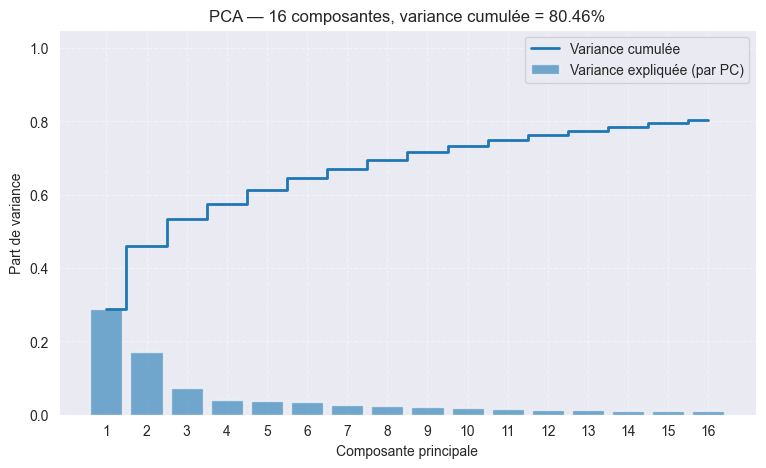

In [87]:
# ============================================
# PCA (sur all_std déjà standardisé) + One-Class SVM
# ============================================

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
import matplotlib.pyplot as plt

# --- 0) Données : all_std est déjà standardisé ---
X = all_std.select_dtypes(include=[np.number]).copy()

mask_valid = X.notna().all(axis=1)
X_clean = X[mask_valid]

pca = PCA(n_components=0.80, random_state=42)
X_pca = pca.fit_transform(X_clean.values)

print(f"Composantes retenues : {pca.n_components_}")
print(f"Variance expliquée cumulée : {pca.explained_variance_ratio_.sum():.2%}")


# plot variance cumulée

import numpy as np
import matplotlib.pyplot as plt

evr = pca.explained_variance_ratio_                  # part de variance par composante
evr_cum = np.cumsum(evr)                             # variance expliquée cumulée
k = pca.n_components_

plt.figure(figsize=(9, 5))
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Variance expliquée (par PC)')
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0, label='Variance cumulée')

plt.xlabel('Composante principale')
plt.ylabel('Part de variance')
plt.title(f'PCA — {k} composantes, variance cumulée = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))  # graduations raisonnables
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()


In [99]:
from sklearn.mixture import GaussianMixture

# === Étape 1 : GMM avec covariance diagonale (comme dans le papier) ===
k_candidates = range(2,5)
bic_rows = []
for k_ in k_candidates:
    g_tmp = GaussianMixture(
        n_components=k_,
        covariance_type="diag",   # <= ICI la clé
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(X_pca)
    bic_rows.append({"k": k_, "BIC": g_tmp.bic(X_pca), "AIC": g_tmp.aic(X_pca)})

bic_df = pd.DataFrame(bic_rows).set_index("k").sort_values("BIC")
best_k = int(bic_df.index[0])
print("Table BIC/AIC :\n", bic_df, "\n")
print(f"Nombre de régimes retenu (BIC) : {best_k}")

# === Étape 2 : Fit final (même paramètres) ===
gmm = GaussianMixture(
    n_components=best_k,
    covariance_type="diag",      # <= clé
    n_init=10,
    reg_covar=1e-6,
    random_state=42
).fit(X_pca)

labels = gmm.predict(X_pca)
probas = gmm.predict_proba(X_pca)
llk    = gmm.score_samples(X_pca)

# === Étape 3 : Lissage temporel optionnel (comme les auteurs) ===
# pour éviter les transitions erratiques entre régimes
win = 3
labels_smooth = (
    pd.Series(labels, index=X_clean.index)
      .rolling(win, min_periods=1)
      .apply(lambda x: np.bincount(x.astype(int)).argmax(), raw=False)
      .astype(int)
)

# Résultats finaux
res_gmm = pd.DataFrame(index=X.index)
res_gmm.loc[mask_valid, "gmm_label"] = labels_smooth
res_gmm.loc[mask_valid, "gmm_loglike"] = llk
for j in range(best_k):
    res_gmm.loc[mask_valid, f"gmm_p{j}"] = probas[:, j]


Table BIC/AIC :
           BIC         AIC
k                        
4 50644.81906 50038.37248
3 50945.63936 50491.96176
2 51125.82090 50824.91229 

Nombre de régimes retenu (BIC) : 4


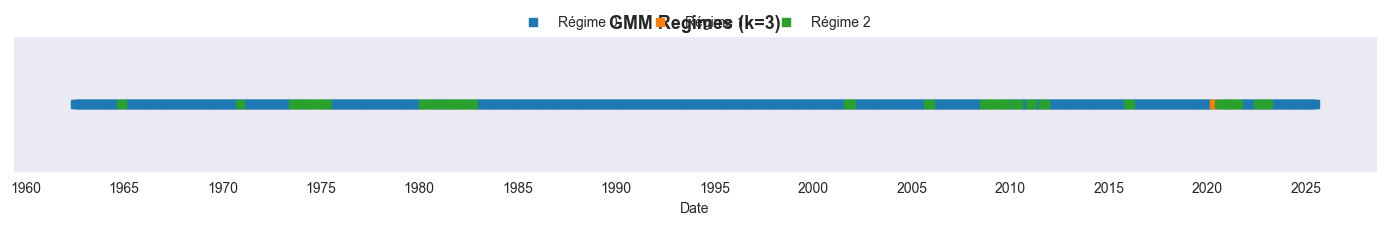

In [100]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import pandas as pd

# --- Données : extraire les labels et l'index temps ---
gmm_labels = res_gmm["gmm_label"].dropna().astype(int)
dates = gmm_labels.index

# --- Palette cohérente ---
n_regimes = gmm_labels.max() + 1
palette = sns.color_palette("tab10", n_colors=n_regimes)

# --- (Optionnel) périodes de récession à ombrer ---
# recession_periods = [
#     ("1973-11-01", "1975-03-01"),
#     ("1980-01-01", "1980-07-01"),
#     ("1981-07-01", "1982-11-01"),
#     ("1990-07-01", "1991-03-01"),
#     ("2001-03-01", "2001-11-01"),
#     ("2007-12-01", "2009-06-01"),
#     ("2020-02-01", "2020-04-01"),
# ]

# --- Figure principale ---
fig, ax = plt.subplots(figsize=(14, 2.5))
ax.set_title(f"GMM Regimes (k={n_regimes})", fontsize=13, weight="bold")

# Plot des points colorés (timeline horizontale)
for k_ in range(n_regimes):
    idx_k = gmm_labels[gmm_labels == k_].index
    ax.scatter(idx_k, [0]*len(idx_k), s=30, color=palette[k_], label=f"Régime {k_}", marker="s")

# Option : récessions ombrées
# for start, end in recession_periods:
#     ax.axvspan(pd.to_datetime(start), pd.to_datetime(end),
#                color="grey", alpha=0.3, lw=0)

# Mise en forme
ax.set_yticks([])
ax.set_xlabel("Date")
ax.xaxis.set_major_locator(mdates.YearLocator(5))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(False)

# Légende centrée
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.25),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout()
plt.show()


Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...
Outliers détectés (OCSVM) : 39 sur 757 observations (5.2%).
Étape 2 : K-means cosinus sur les mois typiques (PCA)...


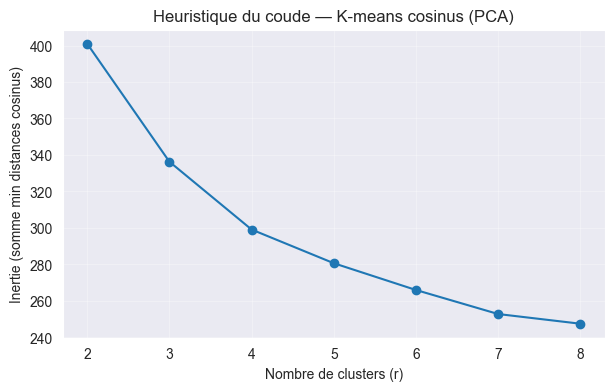

Nombre de régimes réguliers retenu : r = 5
Clustering cosinus terminé.
Étape 3 : Calcul des distributions de probabilité...
Étape 4 : Calcul de la matrice de transition...
Matrice de transition P(i→j) :
        0       1       2       3       4       5
0 0.46200 0.20500 0.10300 0.02600 0.05100 0.15400
1 0.04400 0.90600 0.00000 0.01100 0.00000 0.03900
2 0.07700 0.00000 0.56000 0.06600 0.20900 0.08800
3 0.00000 0.01600 0.05500 0.68800 0.03100 0.21100
4 0.00000 0.00000 0.10800 0.02500 0.82400 0.04400
5 0.05300 0.07000 0.06100 0.22800 0.08800 0.50000

Comptage par régime :
0     39
1    181
2     91
3    128
4    204
5    114
Name: kmeans_label, dtype: int64


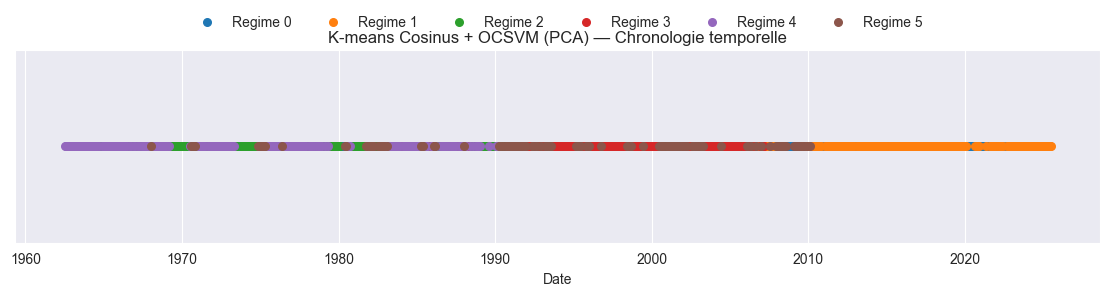

In [106]:
# ============================================
# K-MEANS REGIME DETECTION — VERSION PCA + OCSVM (FIDÈLE AUTEURS)
# ============================================

import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données PCA
X_pca_df = pd.DataFrame(X_pca, index=X_clean.index)
mask_valid = X_pca_df.notna().all(axis=1)
X_pca_df = X_pca_df[mask_valid]
dates = X_pca_df.index

# ----------------------------------------------------
# 1. Détection des outliers via One-Class SVM
# ----------------------------------------------------
print("Étape 1 : Détection des outliers via One-Class SVM (sur PCA)...")

# ν = fraction maximale d'outliers (ex: 0.02 = 2%)
ocs = OneClassSVM(kernel="rbf", nu=0.05, gamma="scale").fit(X_pca_df)
is_outlier = ocs.predict(X_pca_df) == -1
decision_scores = ocs.decision_function(X_pca_df)  # plus petit = plus anormal

# Convertir scores en probabilité approchée (sigmoïde)
from scipy.special import expit
p_reg0 = 1 - expit((decision_scores - np.min(decision_scores)) / (np.std(decision_scores) + 1e-8))

X_typical = X_pca_df.loc[~is_outlier]
dates_typical = X_typical.index
print(f"Outliers détectés (OCSVM) : {is_outlier.sum()} sur {len(X_pca_df)} observations ({100*is_outlier.mean():.1f}%).")

# ----------------------------------------------------
# 2. Vrai K-means Cosinus sur les mois typiques
# ----------------------------------------------------
print("Étape 2 : K-means cosinus sur les mois typiques (PCA)...")

def spherical_kmeans(X, k, max_iter=300, tol=1e-6, random_state=42):
    rng = np.random.default_rng(random_state)
    X = normalize(X, norm='l2')  # chaque observation sur la sphère unité
    n, d = X.shape

    centers = X[rng.choice(n, k, replace=False)]
    centers = normalize(centers, norm='l2')

    for it in range(max_iter):
        sim = X @ centers.T
        labels = np.argmax(sim, axis=1)
        new_centers = np.zeros_like(centers)
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                new_centers[j] = normalize(cluster_points.mean(axis=0).reshape(1, -1))
            else:
                new_centers[j] = centers[j]
        diff = np.linalg.norm(new_centers - centers)
        centers = new_centers
        if diff < tol:
            break
    dist_cos = 1 - (X @ centers.T)
    return labels, centers, dist_cos

# --- Détermination du nombre optimal r
inertias = []
k_range = range(2, 9)
X_typical_np = X_typical.values
for k_ in k_range:
    labels, centers, dist_cos = spherical_kmeans(X_typical_np, k_)
    inertia = np.sum(np.min(dist_cos, axis=1))
    inertias.append(inertia)

plt.figure(figsize=(7, 4))
plt.plot(k_range, inertias, marker='o')
plt.title("Heuristique du coude — K-means cosinus (PCA)")
plt.xlabel("Nombre de clusters (r)")
plt.ylabel("Inertie (somme min distances cosinus)")
plt.grid(True, alpha=0.3)
plt.show()

r = 5  # ajuster selon le coude
print(f"Nombre de régimes réguliers retenu : r = {r}")

cos_labels, cos_centers, cos_dists = spherical_kmeans(X_typical_np, r)
print("Clustering cosinus terminé.")

# ----------------------------------------------------
# 3. Distributions de probabilité (Éqs. 1 et 4)
# ----------------------------------------------------
print("Étape 3 : Calcul des distributions de probabilité...")

cos_probs = 1 - (cos_dists / cos_dists.sum(axis=1, keepdims=True))
cos_probs = cos_probs / cos_probs.sum(axis=1, keepdims=True)

final_probs = pd.DataFrame(index=dates, columns=[f"Regime_{i}" for i in range(r+1)], dtype=float)
final_probs.loc[:, :] = 0.0

Pm = np.max(cos_probs, axis=1)
P0 = p_reg0[~is_outlier]

# Éq. (4) : P_R0 = - Pm * log2(1 - P(Regime 0))
PR0 = -Pm * np.log2(1 - P0)
PR0[np.isnan(PR0)] = 0.0
PR0[PR0 < 0] = 0.0

final_probs.loc[dates_typical, "Regime_0"] = PR0
for j in range(r):
    final_probs.loc[dates_typical, f"Regime_{j+1}"] = cos_probs[:, j]

final_probs.loc[dates[is_outlier], "Regime_0"] = 1.0
final_probs = final_probs.div(final_probs.sum(axis=1), axis=0)

hard_labels = final_probs.idxmax(axis=1).str.extract("(\d+)").astype(int).values.flatten()

# ----------------------------------------------------
# 4. Matrice de transition (Éq. 5)
# ----------------------------------------------------
print("Étape 4 : Calcul de la matrice de transition...")

ordered_labels = pd.Series(hard_labels, index=dates).sort_index()
regimes = np.unique(hard_labels)
transition_matrix = pd.DataFrame(0.0, index=regimes, columns=regimes)

for i in range(len(ordered_labels)-1):
    i_reg = ordered_labels.iloc[i]
    j_reg = ordered_labels.iloc[i+1]
    transition_matrix.loc[i_reg, j_reg] += 1

transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
print("Matrice de transition P(i→j) :")
print(transition_matrix.round(3))

# ----------------------------------------------------
# 5. Visualisation temporelle
# ----------------------------------------------------
res_kmeans = pd.DataFrame({"kmeans_label": hard_labels}, index=dates)
print("\nComptage par régime :")
print(res_kmeans["kmeans_label"].value_counts().sort_index())

palette = sns.color_palette("tab10", n_colors=r+1)
plt.figure(figsize=(14, 2.5))
for k_ in range(r+1):
    idx = res_kmeans.index[res_kmeans["kmeans_label"] == k_]
    plt.scatter(idx, [0]*len(idx), color=palette[k_], s=30, label=f"Regime {k_}")
plt.yticks([])
plt.title(f"K-means Cosinus + OCSVM (PCA) — Chronologie temporelle", fontsize=12)
plt.xlabel("Date")
plt.legend(ncol=r+1, frameon=False, loc="upper center", bbox_to_anchor=(0.5, 1.25))
plt.show()


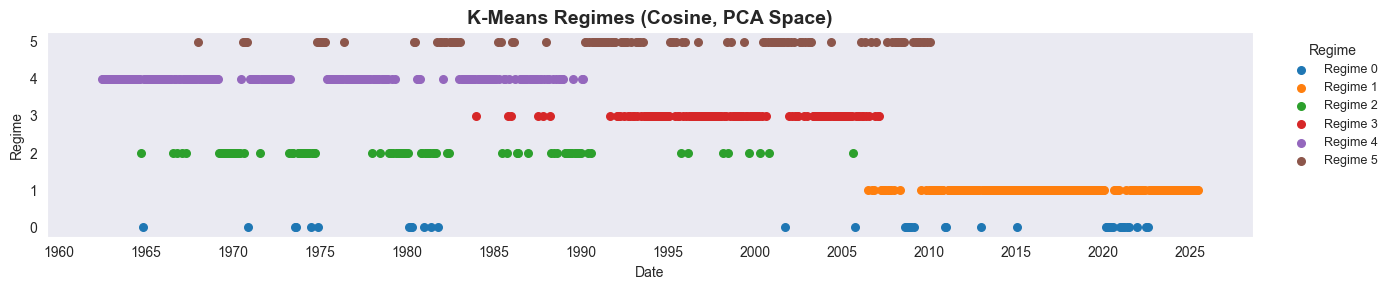

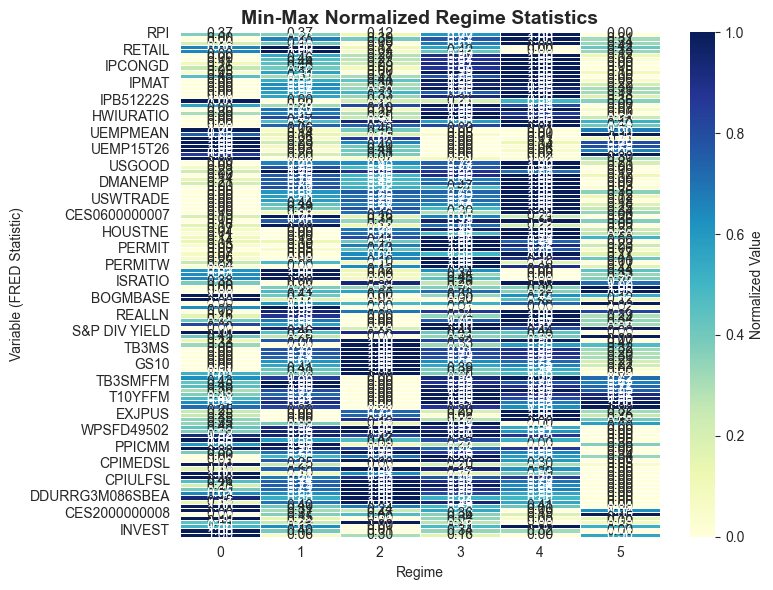

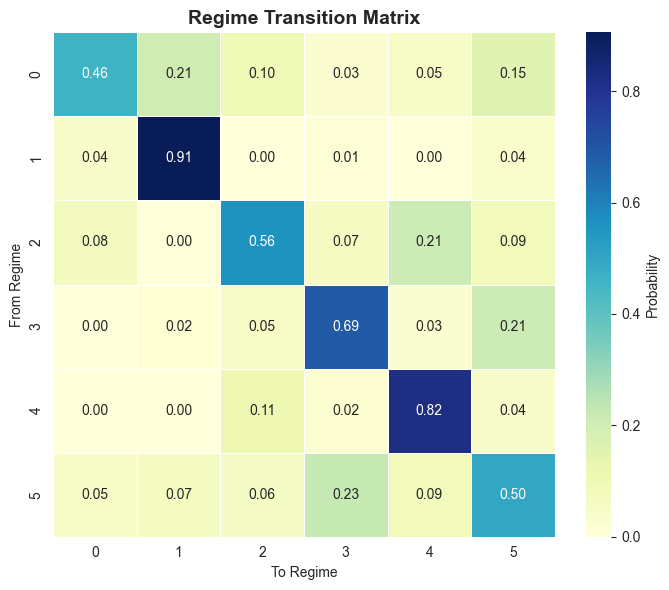

In [107]:
# ==========================================================
# 1. Timeline des régimes K-means (type Figure 6 du papier)
# ==========================================================
import matplotlib.dates as mdates

plt.figure(figsize=(14, 3))
plt.title("K-Means Regimes (Cosine, PCA Space)", fontsize=14, weight='bold')

palette = sns.color_palette("tab10", n_colors=res_kmeans["kmeans_label"].nunique())
for k_ in sorted(res_kmeans["kmeans_label"].unique()):
    idx = res_kmeans.index[res_kmeans["kmeans_label"] == k_]
    plt.scatter(idx, [k_]*len(idx), color=palette[k_], s=30, label=f"Regime {k_}")

plt.yticks(sorted(res_kmeans["kmeans_label"].unique()))
plt.xlabel("Date")
plt.ylabel("Regime")
plt.grid(False)
plt.legend(
    title="Regime",
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    frameon=False,
    fontsize=9,
)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.tight_layout()
plt.show()


# ==========================================================
# 2. Heatmap des statistiques moyennes par régime
#    (type Figure 7 — "Min-Max Normalized Regime Statistics")
# ==========================================================
# On suppose que "all_std" contient toutes tes variables macro standardisées
# et "res_kmeans" contient la colonne "kmeans_label"
common_idx = all_std.index.intersection(res_kmeans.index)
df_plot = all_std.loc[common_idx].copy()
df_plot["Regime"] = res_kmeans.loc[common_idx, "kmeans_label"].values

# Moyennes par régime
mean_stats = df_plot.groupby("Regime").mean().T

# Min-max normalization par variable (ligne)
mean_norm = (mean_stats - mean_stats.min(axis=1).values.reshape(-1, 1)) / (
    mean_stats.max(axis=1).values.reshape(-1, 1) - mean_stats.min(axis=1).values.reshape(-1, 1)
)
mean_norm = mean_norm.fillna(0)

plt.figure(figsize=(8, 6))
sns.heatmap(
    mean_norm,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Normalized Value'}
)
plt.title("Min-Max Normalized Regime Statistics", fontsize=14, weight='bold')
plt.ylabel("Variable (FRED Statistic)")
plt.xlabel("Regime")
plt.tight_layout()
plt.show()


# ==========================================================
# 3. Matrices de transition (type Figure 8 et 9)
# ==========================================================
# --- Matrice brute déjà calculée : transition_matrix
plt.figure(figsize=(7, 6))
sns.heatmap(
    transition_matrix,
    cmap="YlGnBu",
    annot=True,
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={'label': 'Probability'}
)
plt.title("Regime Transition Matrix", fontsize=14, weight='bold')
plt.xlabel("To Regime")
plt.ylabel("From Regime")
plt.tight_layout()
plt.show()